### Conductance and current response to a series of voltage clamp steps
The rate equations are solved using the implicit trapezoid method. Because the HH equations were developed for ms time units and mV voltage, time is kept in ms throughout and voltage is converted to mV within the procedure calculating the HH rates.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Define cell parameters

In [ ]:
diameter = 40                 # um   
A = 4*np.pi*(diameter/2)**2   # µm^2 membrane area
cm_bar = 0.01 *1e-12          # F/µm^2, specific capacitance, 0.01 pF/µm^2

gL_bar = 3.0 *1e-12      # S/µm^2, specific leak conductance, 3 pS/µm^2
VL = -65 *1e-3           # V, reversal potential for leak conductance 

ENa = 50 *1e-3           # V, Na reversal potential
EK = -77 *1e-3           # V, K reversal potential
gNa_bar = 1200 *1e-12    # S/um^2, Na conductance, 1200 pS/um^2
gK_bar = 360 *1e-12      # S/um^2, K conductance, 360 pS/um^2 

Vrest = -80 *1e-3    # V, initial resting membrane potential

# Temperature parameters
T_C = 18.5      # temperature C, 18.5*C
Q10 = 3**((T_C - 6.3)/10)

Calculate cell specific values

In [ ]:
Cm = cm_bar*A    # F
GL = gL_bar*A    # S
GNa = gNa_bar*A  # S
GK = gK_bar*A    # S

print("Area =", round(A), "um^2")
print('Cm =', round(Cm*1e12,1), 'pF')
print('GL =', round(GL*1e9,1), 'nS')
print('GNa =', round(GNa *1e9,1), 'nS')
print('GK =', round(GK*1e9,1), 'nS')

Area = 5027 um^2
Cm = 50.3 pF
GL = 15.1 nS
GNa = 6031.9 nS
GK = 1809.6 nS


Simulation parameters

Time is in ms to be consistent with HH rate equations.

In [ ]:
Tend = 10                       # ms, duration of simulation ms (for K fig)
# Tend = 3                        # ms, duration of simulation ms (for Na fig)
dt = 0.01                       # ms, time step
td = 1/dt                       # inverse time step used to update state variables
t = np.arange(0, Tend+dt, dt)   # time vector
Nt = len(t)-1                   # number of time steps    

Create and initialize voltage clamp matrix

In [ ]:
Vhold = Vrest
stepsize = 10 *1e-3   # V, voltage clamp step size
numSteps = 10         # number of voltage steps
t1 = 2                # ms, start of voltage step (for K fig)
t2 = 6                # ms, end of voltage step (for K fig)
# t1 = 0.5              # ms, start of voltage step (for Na fig)
# t2 = 2.5              # ms, end of voltage step (for Na fig)
Nt1 = round(t1/dt)+1;
Nt2 = round(t2/dt);
Vstep = np.ones((numSteps,Nt+1))*Vhold;
Vstep2 = Vhold      # initial step starts at holding potential
for vs in range(0,numSteps): 
  Vstep[vs,Nt1:Nt2] = Vstep2
  Vstep2 = Vstep2 + stepsize   # increment voltage step

Create and initialize state, conductance and current matrices

In [ ]:
gNa = np.zeros((numSteps,Nt+1))
gK = np.zeros((numSteps,Nt+1))
INa = np.zeros((numSteps,Nt+1))
IK = np.zeros((numSteps,Nt+1))
n = np.zeros(Nt+1)
m = np.zeros(Nt+1)
h = np.zeros(Nt+1)

Calculates HH kinetic rates for a given voltage and temperature

The Hodgkin and Huxley rate equations are defined for the units ms and mV and the output is a dimensionless probability. 

In [ ]:
def Rates(V, Q10):
  V = V*1e3   # convert voltage to mV

  an = 0.01 * (V + 55) / (1 - np.exp(-(V + 55)/10)) * Q10
  bn = 0.125 * np.exp(-(V + 65)/80) * Q10
  am = 0.1 * (V + 40) / (1 - np.exp(-(V + 40)/10)) * Q10
  bm = 4 * np.exp(-(V + 65)/18) * Q10
  ah = 0.07 * np.exp(-(V + 65)/20) * Q10
  bh = 1 / (1 + np.exp(-(V + 35)/10)) * Q10
  return an, bn, am, bm, ah, bh

Solve equations using implicit trapezoid method

In [ ]:
for vs in range(0, numSteps):
  # Initialize voltage and state vectors
  V = Vstep[vs,1];
  an, bn, am, bm, ah, bh = Rates(V, Q10)
  n[0] = an /(an + bn) 
  m[0] = am /(am + bm) 
  h[0] = ah /(ah + bh) 
 
  gK[vs,0] = GK*n[0]**4
  gNa[vs,0] = GNa*m[0]**3*h[0]

  # Implicit Trapezoid 
  for j in range(0,Nt):
    V = Vstep[vs,j]
    an, bn, am, bm, ah, bh = Rates(V, Q10) 
    c = (an + bn)/2
    n[j+1] = ( (td - c)* n[j] + an ) / (td + c)
    c = (am + bm)/2
    m[j+1] = ( (td - c)* m[j] + am ) / (td + c)
    c = (ah + bh)/2
    h[j+1] = ( (td - c)* h[j] + ah ) / (td + c)

    gK[vs,j+1] = GK*n[j+1]**4
    gNa[vs,j+1] = GNa*m[j+1]**3*h[j+1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


Calculate conductance and current values and convert units for plotting

In [ ]:
# calculate currents from conductance values in mA
IK = gK*(Vstep-EK)       # A
INa = gNa*(Vstep-ENa)    # A

# convert units for plotting
Vstep = Vstep *1e3    # V to mV
gK = gK *1e6          # S to uS
gNa = gNa *1e6        # S to uS
IK = IK *1e9          # A to nA
INa = INa *1e9        # A to nA

Plot results

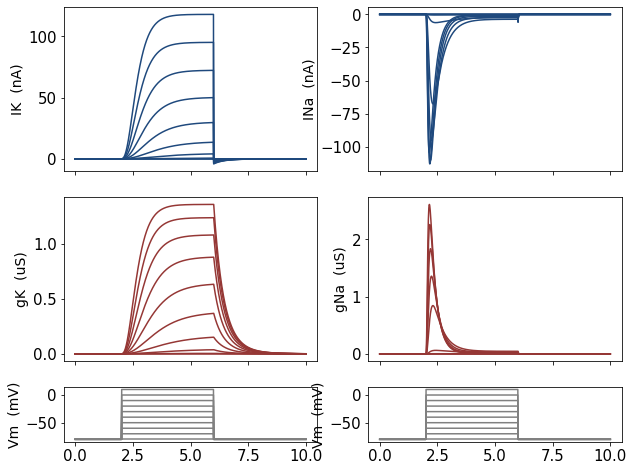

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
f, axs = plt.subplots(3, 2, gridspec_kw={'height_ratios': [3, 3, 1]}, sharex='all')

axs[0, 0].plot(t,IK.T, '#1F497D')
axs[0, 0].set_ylabel('IK  (nA)', fontsize=14)

axs[1, 0].plot(t,gK.T, '#953735')
axs[1, 0].set_ylabel('gK  (uS)', fontsize=14)

axs[2, 0].plot(t,Vstep.T, 'grey')
axs[2, 0].set_ylabel('Vm  (mV)', fontsize=14)

axs[0, 1].plot(t,INa.T, '#1F497D')
axs[0, 1].set_ylabel('INa  (nA)', fontsize=14)

axs[1, 1].plot(t,gNa.T, '#953735')
axs[1, 1].set_ylabel('gNa  (uS)', fontsize=14)

axs[2, 1].plot(t,Vstep.T, 'grey')
axs[2, 1].set_ylabel('Vm  (mV)', fontsize=14)

plt.show() # suppresses return values